## Описание проекта <br>
Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта
1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

Импорт библиотек

In [166]:
!pip install --upgrade scikit-learn --quiet

In [167]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose
from xgboost import XGBRegressor

In [168]:
RANDOM_STATE = 42

### Шаг 1. Загрузка данных

In [169]:
taxi = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv')

In [170]:
taxi.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [171]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [172]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Приведём datetime к типу данных datetime

In [173]:
taxi['datetime'] = pd.to_datetime(taxi['datetime'])

In [174]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Ресемплируем данные по одному часу

In [175]:
taxi = taxi.set_index('datetime').resample('1h').sum()

taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


#### Промежуточный вывод <br>
Данные загружены, приведены к типу datetime и ресемплированы по одному часу.

### Шаг 2. Анализ данных

Посмотрим за какой период у нас есть данные

In [176]:
taxi.index.min(), taxi.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:00:00'))

У нас доступны данные за 6 месяцев с марта по август 2018 года (включительно).

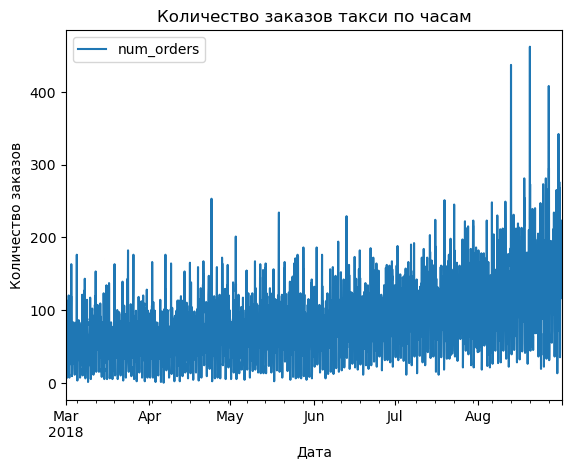

In [177]:
taxi.plot()
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.title('Количество заказов такси по часам')
plt.show();

In [178]:
decomposed = seasonal_decompose(taxi)

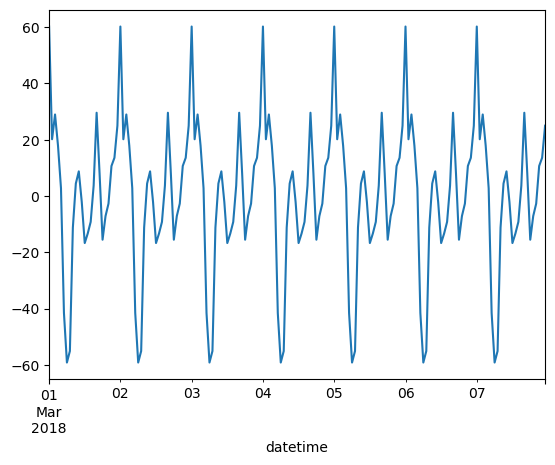

In [179]:
# Сезонность за неделю
decomposed.seasonal['2018-03-01':'2018-03-07'].plot();

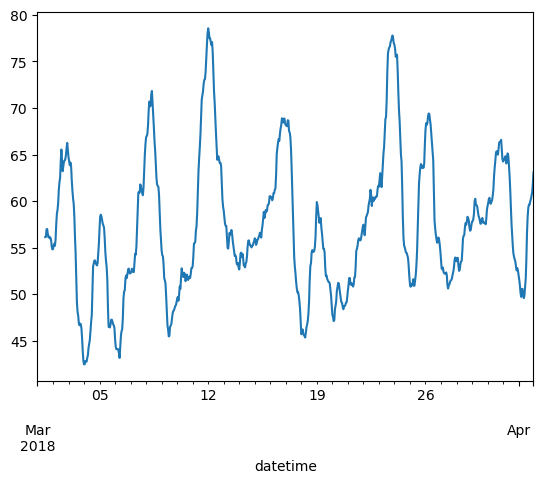

In [180]:
# Тренд за месяц
decomposed.trend['2018-03-01':'2018-04-01'].plot();

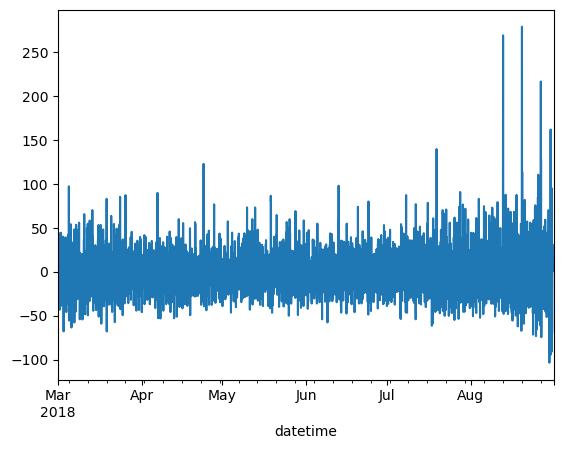

In [181]:
# Остатки
decomposed.resid.plot();

#### Промежуточный вывод <br>
Данные за период с марта по август 2018 года. По графику видно, что количество заказов такси растёт к концу периода. Пики приходятся на дни праздников и время отпусков. Особенно это заметно в конце августа. В течение каждого месяца также видны пики в выходные дни.

### Шаг 3. Обучение моделей

In [182]:
def make_features(data, max_lag, rolling_mean_size):
    data_copy = data.copy()

    data_copy['year'] = data_copy.index.year
    data_copy['month'] = data_copy.index.month
    data_copy['day'] = data_copy.index.day
    data_copy['dayofweek'] = data_copy.index.dayofweek

    lag_features = {f'lag_{lag}': data['num_orders'].shift(lag) for lag in range(1, max_lag + 1)}
    lag_df = pd.DataFrame(lag_features)

    rolling_mean = data['num_orders'].shift().rolling(rolling_mean_size).mean()

    final_df = pd.concat([data_copy, lag_df], axis=1)
    final_df['rolling_mean'] = rolling_mean

    return final_df

In [183]:
def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [184]:
best_rmse = float('inf')
best_params = None

lags = range(1, 100, 5)
rolling_means = range(1, 100, 5)

for max_lag in lags:
    for rolling_mean_size in rolling_means:
        taxi_features = make_features(taxi, max_lag, rolling_mean_size)

        train, test = train_test_split(taxi_features, shuffle=False, test_size=0.1)

        train = train.dropna()

        X_train = train.drop('num_orders', axis=1)
        y_train = train['num_orders']

        X_test = test.drop('num_orders', axis=1)
        y_test = test['num_orders']

        model = LinearRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        rmse_lr = rmse(y_test, y_pred)

        # Проверяем, является ли текущий RMSE лучшим
        if rmse_lr < best_rmse:
            best_rmse = rmse_lr
            best_params = {'max_lag': max_lag, 'rolling_mean_size': rolling_mean_size}

# Выводим лучший результат
print(f"Лучший RMSE: {best_rmse}")
print(f"Параметры: {best_params}")

Лучший RMSE: 41.582406079728386
Параметры: {'max_lag': 96, 'rolling_mean_size': 86}


Применим лучшие параметры для создания новых признаков

In [185]:
taxi_features = make_features(taxi, best_params['max_lag'], best_params['rolling_mean_size'])

In [186]:
# Разделим данные на обучающую и тестовую выборки
train, test = train_test_split(taxi_features, shuffle=False, test_size=0.1, random_state=RANDOM_STATE)

train = train.dropna()

In [187]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']

X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

In [188]:
tscv = TimeSeriesSplit(n_splits=5)

In [189]:
results = pd.DataFrame(columns=['model', 'cv_rmse'])

#### Линейная регрессия

In [190]:
ridge_model = Ridge(random_state=RANDOM_STATE)

param_grid_lr = {
    'alpha': [0.01, 0.1, 1, 10, 100]  
}

In [191]:
grid_search_lr = GridSearchCV(
    estimator=ridge_model,
    param_grid=param_grid_lr,
    scoring=rmse_scorer, 
    cv=tscv,
    verbose=1
)

grid_search_lr.fit(X_train, y_train)

best_params_lr = grid_search_lr.best_params_
best_score_lr = -grid_search_lr.best_score_

print(f"Лучшие параметры для Ridge-регрессии: {best_params_lr}")
print(f"RMSE на кросс-валидации для Ridge-регрессии: {best_score_lr}")

new_row_lr = pd.DataFrame({'model': ['Ridge'], 'cv_rmse': [best_score_lr]})
results = pd.concat([results, new_row_lr], ignore_index=True)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры для Ridge-регрессии: {'alpha': 0.01}
RMSE на кросс-валидации для Ridge-регрессии: 23.849325583554783


/var/folders/38/zll4hxn94739278yzc2l5hl40000gn/T/ipykernel_6915/3642383142.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row_lr], ignore_index=True)


RMSE линейной регрессии: 23.8 < 48 - условие задачи выполнено

#### Случайный лес

In [192]:
rf_model = RandomForestRegressor(random_state=RANDOM_STATE)

param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

In [193]:
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring=rmse_scorer,
    cv=tscv,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

best_params_rf = grid_search_rf.best_params_
best_score_rf = -grid_search_rf.best_score_

print(f"Лучшие параметры для случайного леса: {best_params_rf}")
print(f"RMSE на кросс-валидации для случайного леса: {best_score_rf}")

new_row_rf = pd.DataFrame({'model': ['RandomForest'], 'cv_rmse': [best_score_rf]})
results = pd.concat([results, new_row_rf], ignore_index=True)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Лучшие параметры для случайного леса: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
RMSE на кросс-валидации для случайного леса: 24.17747546564962


RMSE случайного леса: 24.18 < 48 - условие задачи выполнено.

#### XGBoost (градиентный бустинг)

In [194]:
model = XGBRegressor(random_state=RANDOM_STATE)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [195]:
grid_search_xgb = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=tscv,
    verbose=1
)

grid_search_xgb.fit(X_train, y_train)

# Лучшие параметры
best_params = grid_search_xgb.best_params_
best_score = -grid_search_xgb.best_score_

print(f"Лучшие параметры: {best_params}")
print(f"RMSE на кросс-валидации: {best_score}")

new_row = pd.DataFrame({'model': ['XGBoost'], 'cv_rmse': [best_score]})
results = pd.concat([results, new_row], ignore_index=True)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
RMSE на кросс-валидации: 23.753068471735382


RMSE XGBoost: 23.75 < 48 - условие задачи выполнено.

In [196]:
results.sort_values(by='cv_rmse')

,model,cv_rmse
2,XGBoost,23.753068
0,Ridge,23.849326
1,RandomForest,24.177475


#### Промежуточный вывод <br>
Все три модели показали похожий результат после подбора гиперпараметров - ~24. Однако лучший результат показала модель XGBoost с RMSE 23.75 на кросс-валидации.

### Шаг 4. Тестирование

Возьмём лучшую модель и проверим её на тестовой выборке

In [202]:
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse_test = rmse(y_test, y_pred)

print(f'RMSE на тестовой выборке: {rmse_test}')

RMSE на тестовой выборке: 40.61633322010748


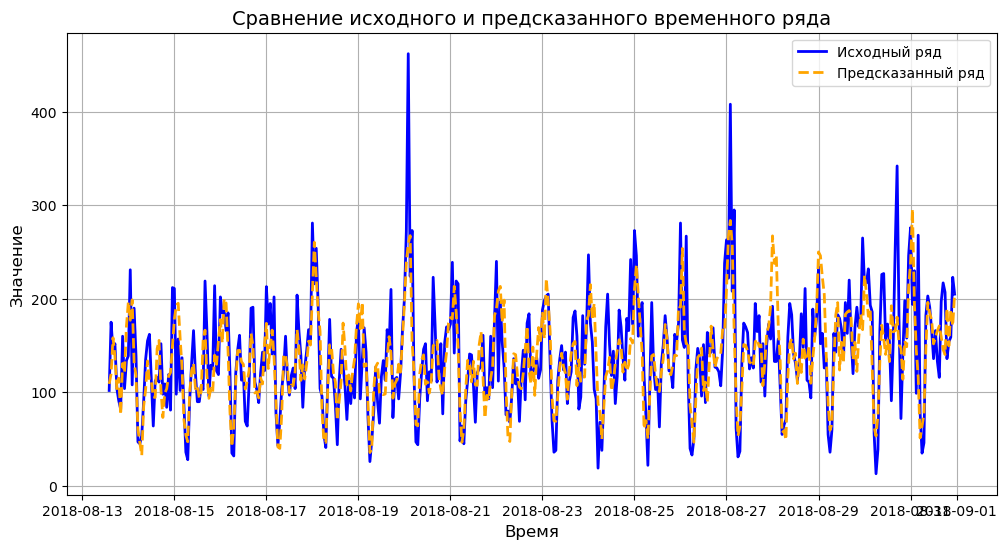

In [203]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Исходный ряд', color='blue', linewidth=2)
plt.plot(y_test.index, y_pred, label='Предсказанный ряд', color='orange', linestyle='--', linewidth=2)
plt.title('Сравнение исходного и предсказанного временного ряда', fontsize=14)
plt.xlabel('Время', fontsize=12)
plt.ylabel('Значение', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

#### Промежуточный вывод <br>
Из графика видно, что предсказания модели близки к исходному ряду. RMSE на тестовой выборке составил 40.6, что также удовлетворяет условиям задачи. Модель плохо предсказывает пики, но в целом хорошо справляется с предсказанием.

### Общий вывод <br>
В ходе выполнения проекта были выполнены следующие шаги:
1. Загружены и проанализированы данные.
2. Данные ресемплированы по одному часу.
3. Обучены модели линейной регрессии, случайного леса и XGBoost.
4. Подобраны гиперпараметры для моделей.
5. Проверены модели на тестовой выборке.
6. Построен график сравнения исходного и предсказанного временного ряда.
7. Получены следующие результаты:
    - RMSE линейной регрессии: 23.8
    - RMSE случайного леса: 24.18
    - RMSE XGBoost: 23.75
    - RMSE на тестовой выборке XGBoost: 40.6

<br>
Модель XGBoost показала наилучший результат на кросс-валидации. Предсказания модели близки к исходному ряду, однако плохо предсказываются пики. 